In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.offsetbox import AnchoredText
from datetime import datetime, timedelta
from scipy import signal
from scipy.signal import find_peaks, butter, filtfilt, hilbert, welch
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
np.random.seed(42)

for dirname, _, filenames in os.walk('datasets2'):
    dataFile_quant = np.empty(len(filenames), dtype='object')
    for ii, filename in enumerate(filenames, start=0):
        dataFile_quant[ii] = (os.path.join(dirname, filename))
        print(os.path.join(dirname, filename))

featuresDF = pd.DataFrame(columns=['time', 'signal', 'inPhase', 'quadrature', 'frequency', 'amplitude', 'phase', 'snr'])
for ii in range(len(dataFile_quant)):
    df_time = np.transpose(np.array(pd.read_csv(dataFile_quant[ii], header= None, usecols=[0], dtype='float64')))[0]
    df_gen = np.transpose(np.array(pd.read_csv(dataFile_quant[ii], header= None, usecols=[1], dtype='float64')))[0]
    analytical_data = hilbert(df_gen)
    df_ip = analytical_data.real
    df_quad = analytical_data.imag
    df_freq  = float(os.path.split(dataFile_quant[ii])[1].split('.csv')[0].split('_')[5])
    df_amp   = float(os.path.split(dataFile_quant[ii])[1].split('.csv')[0].split('_')[7])
    df_phase = float(os.path.split(dataFile_quant[ii])[1].split('.csv')[0].split('_')[9])
    df_snr =   int(os.path.split(dataFile_quant[ii])[1].split('.csv')[0].split('_')[11])
    featuresDF = featuresDF.append({'time': df_time,
                                    'signal': df_gen, 
                                    'inPhase': df_ip, 'quadrature': df_quad,
                                    'frequency': df_freq,
                                    'amplitude': df_amp, 'phase': df_phase,
                                    'snr': df_snr}, ignore_index=True)

#featuresDF['frequency'] = pd.to_numeric(featuresDF['frequency'])
featuresDF['snr'] = pd.to_numeric(featuresDF['snr'])
print(featuresDF.head())
print("\nData Types")
print(featuresDF.dtypes)

featuresDF.to_pickle('dataFrames/featuresDF2.p')

In [4]:
featuresDF = pd.read_pickle('dataFrames/featuresDF2.p')
print(featuresDF.head())
#print(featuresDF.snr.to_string())

                                                time  \
0  [0.0, 5.0025012506253105e-09, 1.00050025012506...   
1  [0.0, 5.0025012506253105e-09, 1.00050025012506...   
2  [0.0, 5.0025012506253105e-09, 1.00050025012506...   
3  [0.0, 5.0025012506253105e-09, 1.00050025012506...   
4  [0.0, 5.0025012506253105e-09, 1.00050025012506...   

                                              signal  \
0  [-0.0492304625580017, 0.0327030924190087, 0.09...   
1  [0.0527251765934891, 0.017049429611942, -0.040...   
2  [-0.0085385153947489, 0.0543612558972888, 0.07...   
3  [-0.0097275397961656, 0.0307058247435442, 0.04...   
4  [-0.0409156108864265, 0.0013119497930588, 0.00...   

                                             inPhase  \
0  [-0.04923046255800172, 0.03270309241900869, 0....   
1  [0.05272517659348908, 0.017049429611941985, -0...   
2  [-0.008538515394748905, 0.05436125589728879, 0...   
3  [-0.009727539796165604, 0.030705824743544205, ...   
4  [-0.0409156108864265, 0.0013119497930588011

In [5]:
fs = 200e6        # Simulation sampling rate (Hz)
fs_adc = 100e6    # ADC sampling rate (Hz)
t_end = 1e-5     # Simulation end time (seconds)
t = np.linspace(0, t_end, int(fs*t_end))
print("There are {} elements per sample".format(len(t)))

There are 2000 elements per sample


In [6]:
# Which Figure to show for examples
showFig = 100

Signal Frequency: 4000000.0
Signal Amplitude: 0.1
Signal Phase:     70.0


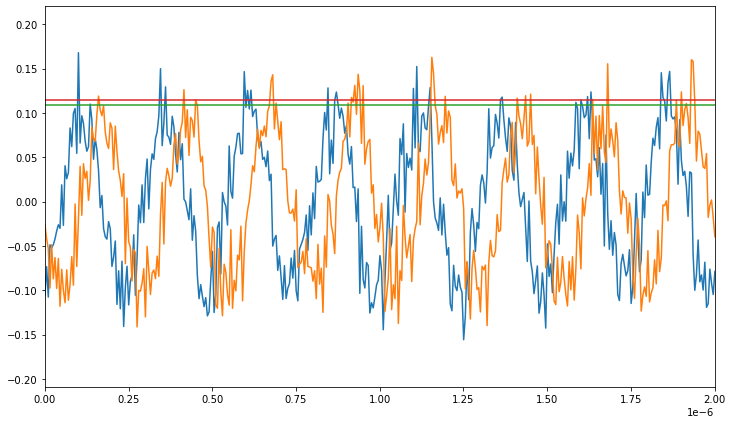

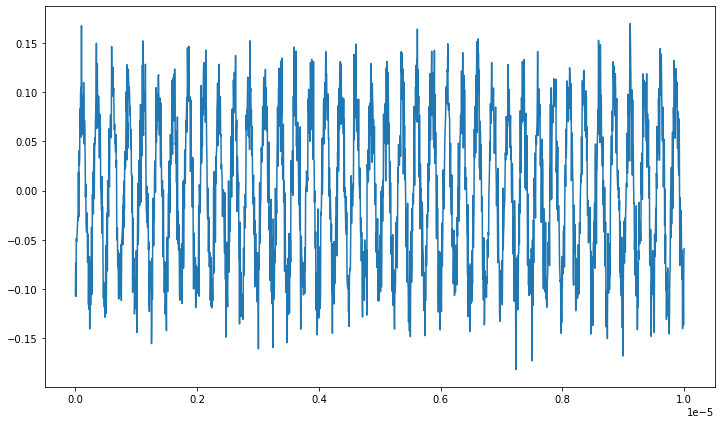

In [7]:
#IQ Data testing
def FilteredSignal(signal, fs, cutoff):
    B, A = butter(1, cutoff / (fs / 2), btype='low')
    filtered_signal = filtfilt(B, A, signal, axis=0)
    return filtered_signal

time = featuresDF.at[showFig, 'time']
testdata = featuresDF.at[showFig, 'signal']
cutoff = featuresDF.at[showFig, 'frequency']
analytical_testdata = hilbert(testdata)
amplitudeEnvelope = np.abs(analytical_testdata)
filteredSignal = FilteredSignal(amplitudeEnvelope, fs, cutoff)

print("Signal Frequency: {}".format(featuresDF.at[showFig,'frequency']))
print("Signal Amplitude: {}".format(featuresDF.at[showFig,'amplitude']))
print("Signal Phase:     {}".format(featuresDF.at[showFig,'phase']))
plt.figure(figsize=(12,7))
plt.xlim(0,2e-6)
plt.plot(time, analytical_testdata.real)
plt.plot(time, analytical_testdata.imag)
plt.plot(amplitudeEnvelope)
plt.plot(filteredSignal)

plt.figure(figsize=(12,7))
plt.plot(time, testdata)

In [8]:
iq_sig = featuresDF.at[showFig, 'inPhase']*np.cos(2*np.pi*fs*t) - featuresDF.at[showFig, 'quadrature']*np.sin(2*np.pi*fs*t)

Signal Frequency: 4000000.0
Signal Amplitude: 0.1
Signal Phase:     70.0


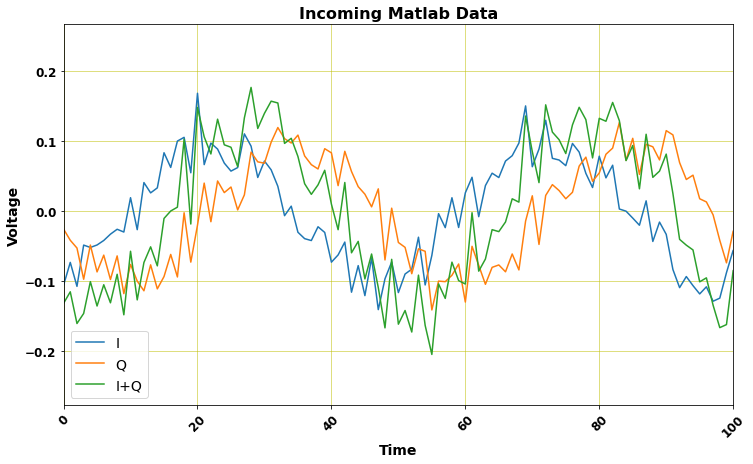

In [9]:
print("Signal Frequency: {}".format(featuresDF.at[showFig,'frequency']))
print("Signal Amplitude: {}".format(featuresDF.at[showFig,'amplitude']))
print("Signal Phase:     {}".format(featuresDF.at[showFig,'phase']))
plt.figure(figsize=(12,7))
plt.plot(featuresDF.at[showFig, 'inPhase'])
plt.plot(featuresDF.at[showFig, 'quadrature'])
plt.plot(featuresDF.at[showFig, 'inPhase'] + featuresDF.at[showFig, 'quadrature'])
plt.legend(['I', 'Q', 'I+Q'], loc='lower left', prop={'size': 14})
plt.title('Incoming Matlab Data', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Voltage', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)
plt.xlim(0,100)
plt.show()

Signal Frequency: 4000000.0
Signal Amplitude: 0.1
Signal Phase:     70.0


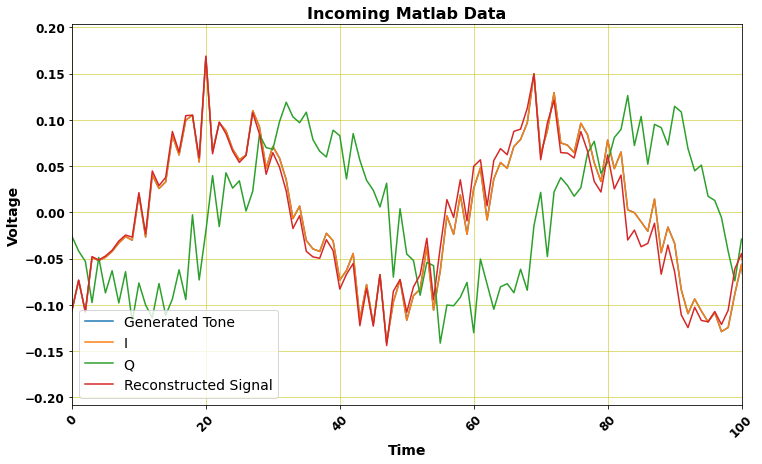

In [10]:
print("Signal Frequency: {}".format(featuresDF.at[showFig,'frequency']))
print("Signal Amplitude: {}".format(featuresDF.at[showFig,'amplitude']))
print("Signal Phase:     {}".format(featuresDF.at[showFig,'phase']))
plt.figure(figsize=(12,7))
plt.plot(featuresDF.at[showFig, 'signal'])
plt.plot(featuresDF.at[showFig, 'inPhase'])
plt.plot(featuresDF.at[showFig, 'quadrature'])
plt.plot(iq_sig)
plt.legend(['Generated Tone', 'I', 'Q', 'Reconstructed Signal'], loc='lower left', prop={'size': 14})
plt.title('Incoming Matlab Data', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Voltage', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)
plt.xlim(0,100)
plt.show()

Signal Frequency: 4000000.0
Signal Amplitude: 0.1
Signal Phase:     70.0


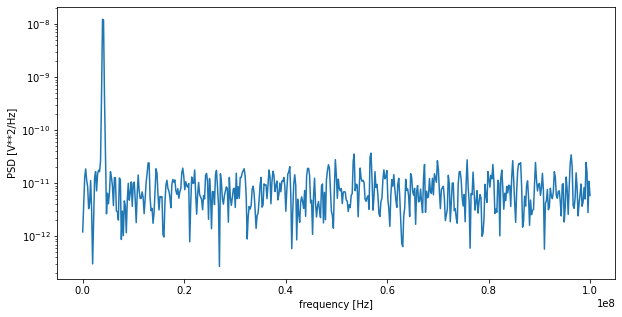

In [11]:
f, Pxx_den = welch(featuresDF.at[showFig,'signal'], fs, nperseg=1024)

print("Signal Frequency: {}".format(featuresDF.at[showFig,'frequency']))
print("Signal Amplitude: {}".format(featuresDF.at[showFig,'amplitude']))
print("Signal Phase:     {}".format(featuresDF.at[showFig,'phase']))
plt.figure(figsize=(10,5))
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape data
signal_df_r = featuresDF.copy(deep=True)
signal_df_r['iq'] = ''
for ii in range(0, len(signal_df_r)):
    signal_sample = signal_df_r.at[ii,'signal']
    i_sample = signal_df_r.at[ii,'inPhase']
    q_sample = signal_df_r.at[ii,'quadrature']

    # Reshape the dataset
    signal_sample = np.asarray(signal_sample).reshape(-1,1)
    i_sample = np.asarray(i_sample).reshape(-1,1)
    q_sample = np.asarray(q_sample).reshape(-1,1)

    # Normalize the dataset
    #signal_sample = scaler.fit_transform(signal_sample)
    #i_sample = scaler.fit_transform(i_sample)
    #q_sample = scaler.fit_transform(q_sample)

    # Remove extra dimension
    signal_df_r.at[ii,'signal'] = np.array(signal_sample).squeeze()

    iq_sample = np.concatenate([i_sample, q_sample], axis=1)

    #iq_sample = signal_sample.reshape((iq_sample.shape[0], iq_sample.shape[1], 1))
    iq_sample = np.expand_dims(iq_sample, 2)
    signal_df_r.at[ii,'iq'] = np.array(iq_sample)

In [13]:
print(signal_df_r.shape)
print(signal_df_r.at[showFig,'iq'].shape)
print(signal_df_r.at[showFig,'signal'].shape)

(14000, 9)
(2000, 2, 1)
(2000,)


In [14]:
#Split the dataset 
from sklearn.model_selection import train_test_split 
train_df, test_validation_df = train_test_split(signal_df_r, train_size=0.8, test_size=0.2, random_state = 42, shuffle=True)
valid_df, test_df = train_test_split(test_validation_df, train_size=0.5, test_size=0.5, random_state = 42, shuffle=True)
print("Shape of train inputs {}, train target {}".format(train_df['signal'].iloc[0].shape, train_df.shape))
print("Shape of validation inputs {}, validation target {}".format(valid_df['signal'].iloc[0].shape, valid_df.shape))
print("Shape of test inputs {}, test target {}".format(test_df['signal'].iloc[0].shape, test_df.shape))

Shape of train inputs (2000,), train target (11200, 9)
Shape of validation inputs (2000,), validation target (1400, 9)
Shape of test inputs (2000,), test target (1400, 9)


In [15]:
#Extract Data from Dataframe
train_features = np.array(train_df.iq.to_list()).squeeze()
valid_features = np.array(valid_df.iq.to_list()).squeeze()
test_features = np.array(test_df.iq.to_list()).squeeze()

train_freq_labels = np.array(train_df.frequency.to_list())/10e5
valid_freq_labels = np.array(valid_df.frequency.to_list())/10e5
test_freq_labels = np.array(test_df.frequency.to_list())/10e5

train_amp_labels = np.array(train_df.amplitude.to_list())
valid_amp_labels = np.array(valid_df.amplitude.to_list())
test_amp_labels = np.array(test_df.amplitude.to_list())

train_phase_labels = np.array(train_df.phase.to_list())
valid_phase_labels = np.array(valid_df.phase.to_list())
test_phase_labels = np.array(test_df.phase.to_list())

test_signal_labels = np.array(test_df.signal.to_list())
test_snr_labels = np.array(test_df.snr.to_list())

In [16]:
print(train_features.shape)
print(train_freq_labels.shape)
print(train_amp_labels.shape)
print(train_phase_labels.shape)

(11200, 2000, 2)
(11200,)
(11200,)
(11200,)


for ii in range(len(train_labels)):
    print(f"Index: {ii} | Amp Val: {train_labels[ii]}")

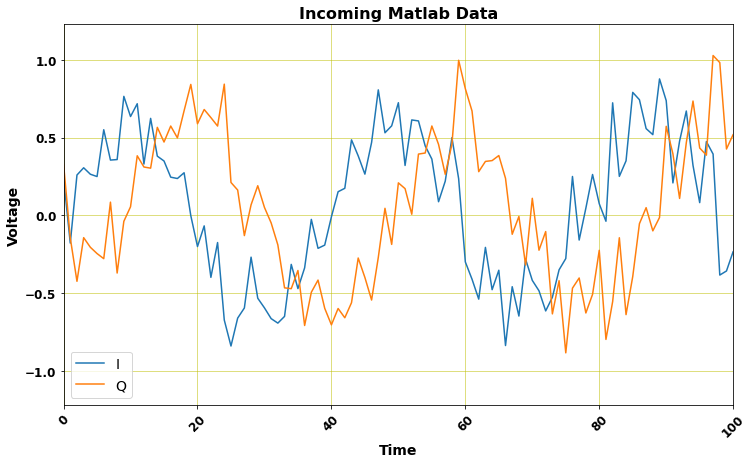

In [17]:
plt.figure(figsize=(12,7))
plt.plot(train_features[showFig,:,0]) #inPhase
plt.plot(train_features[showFig,:,1]) #quadrature
plt.legend(['I', 'Q'], loc='lower left', prop={'size': 14})
plt.title('Incoming Matlab Data', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Voltage', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)
plt.xlim(0,100)
plt.show()

In [18]:
#Import TensorFlow Libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, \
                                    ReLU, LeakyReLU, Flatten, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras import initializers

#ADDED CONFIG OPTIONS FOR STABILTY
#TensorFlow allocating all of the GPU memory 
#to itself when it initialises the session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
#Reset Default graph - Needed only for Jupyter Notebook
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(42)

In [19]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [20]:
# Model configuration
batch_size = 1024
no_epochs = 300
verbosity = 1

In [21]:
modelType = "DNN"
modelName = "nanoConvPaper_v5.2_pred3"

In [22]:
modelDir = 'models'
modelSaveFile = modelDir + "\\" + modelType + "\\" + modelName + '.h5'

#Setup Model Layers
input_layer = Input(shape=(2000,2))
#regressor = BatchNormalization()(input_layer)

regressor = LSTM(1, return_sequences=True)(input_layer)
regressor = Flatten()(regressor)
#regressor = Dropout(0.5)(regressor)

regressor = Dense(2)(regressor)
regressor = LeakyReLU()(regressor)
#regressor = BatchNormalization()(regressor)
#regressor = Dropout(0.5)(regressor)
regressor = Dense(2)(regressor)
regressor = LeakyReLU()(regressor)
#regressor = Dropout(0.25)(regressor)
regressor = Dense(3)(regressor)
regressor = LeakyReLU()(regressor)
#regressor = Flatten()(regressor)

#Setup Multi-Output
freq_extract = Dense(1, activation=None, name='freq_extract')(regressor)
amp_extract = Dense(1, activation=None, name='amp_extract')(regressor)
phase_extract = Dense(1, activation=None, name='phase_extract')(regressor)

#Setup Model Layers
input_layer = Input(shape=(2000,2))

freq_regressor = LSTM(1, return_sequences=True)(input_layer)
freq_regressor = Flatten()(freq_regressor)
freq_regressor = Dense(2)(freq_regressor)
freq_regressor = LeakyReLU()(freq_regressor)
#freq_regressor = Dropout(0.5)(freq_regressor)
freq_regressor = Dense(2)(freq_regressor)
freq_regressor = LeakyReLU()(freq_regressor)
#freq_regressor = Dropout(0.25)(freq_regressor)
freq_regressor = Dense(3)(freq_regressor)
freq_regressor = LeakyReLU()(freq_regressor)
#freq_regressor = Flatten()(freq_regressor)

amp_regressor = LSTM(1, return_sequences=True)(input_layer)
amp_regressor = Flatten()(amp_regressor)
amp_regressor = Dense(2)(amp_regressor)
amp_regressor = LeakyReLU()(amp_regressor)
#amp_regressor = Dropout(0.5)(amp_regressor)
amp_regressor = Dense(2)(amp_regressor)
amp_regressor = LeakyReLU()(amp_regressor)
#amp_regressor = Dropout(0.25)(amp_regressor)
amp_regressor = Dense(3)(amp_regressor)
amp_regressor = LeakyReLU()(amp_regressor)
#amp_regressor = Flatten()(amp_regressor)

phase_regressor = LSTM(1, return_sequences=True)(input_layer)
phase_regressor = Flatten()(phase_regressor)
phase_regressor = Dense(2)(phase_regressor)
phase_regressor = LeakyReLU()(phase_regressor)
#phase_regressor = Dropout(0.5)(phase_regressor)
phase_regressor = Dense(2)(phase_regressor)
phase_regressor = LeakyReLU()(phase_regressor)
#phase_regressor = Dropout(0.25)(phase_regressor)
phase_regressor = Dense(3)(phase_regressor)
phase_regressor = LeakyReLU()(phase_regressor)
#phase_regressor = Flatten()(phase_regressor)

#Setup Multi-Output
freq_extract = Dense(1, activation=None, name='freq_extract')(freq_regressor)
amp_extract = Dense(1, activation=None, name='amp_extract')(amp_regressor)
phase_extract = Dense(1, activation=None, name='phase_extract')(phase_regressor)

In [59]:
#Setup Model Layers
input_layer = Input(shape=(2000,2))

regressor = LSTM(1, return_sequences=True)(input_layer)
regressor = Flatten()(regressor)

freq_regressor = Dense(2)(regressor)
freq_regressor = LeakyReLU()(freq_regressor)
#freq_regressor = Dropout(0.5)(freq_regressor)
freq_regressor = Dense(2)(freq_regressor)
freq_regressor = LeakyReLU()(freq_regressor)
#freq_regressor = Dropout(0.25)(freq_regressor)
freq_regressor = Dense(3)(freq_regressor)
freq_regressor = LeakyReLU()(freq_regressor)
#freq_regressor = Flatten()(freq_regressor)

amp_regressor = LSTM(1, return_sequences=True)(input_layer)
amp_regressor = Flatten()(amp_regressor)
amp_regressor = Dense(2)(amp_regressor)
amp_regressor = LeakyReLU()(amp_regressor)
#amp_regressor = Dropout(0.5)(amp_regressor)
amp_regressor = Dense(2)(amp_regressor)
amp_regressor = LeakyReLU()(amp_regressor)
#amp_regressor = Dropout(0.25)(amp_regressor)
amp_regressor = Dense(3)(amp_regressor)
amp_regressor = LeakyReLU()(amp_regressor)
#amp_regressor = Flatten()(amp_regressor)

phase_regressor = Dense(2)(regressor)
phase_regressor = LeakyReLU()(phase_regressor)
#phase_regressor = Dropout(0.5)(phase_regressor)
phase_regressor = Dense(2)(phase_regressor)
phase_regressor = LeakyReLU()(phase_regressor)
#phase_regressor = Dropout(0.25)(phase_regressor)
phase_regressor = Dense(3)(phase_regressor)
phase_regressor = LeakyReLU()(phase_regressor)
#phase_regressor = Flatten()(phase_regressor)

#Setup Multi-Output
freq_extract = Dense(1, activation=None, name='freq_extract')(freq_regressor)
amp_extract = Dense(1, activation=None, name='amp_extract')(amp_regressor)
phase_extract = Dense(1, activation=None, name='phase_extract')(phase_regressor)

In [60]:
#Create Keras Model
model = Model(inputs=input_layer,
              outputs=[freq_extract, amp_extract, phase_extract]) #Output layer added

In [61]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2000, 2)]    0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 2000, 1)      16          input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 2000, 1)      16          input_3[0][0]                    
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 2000)         0           lstm_3[0][0]                     
_______________________________________________________________________________________

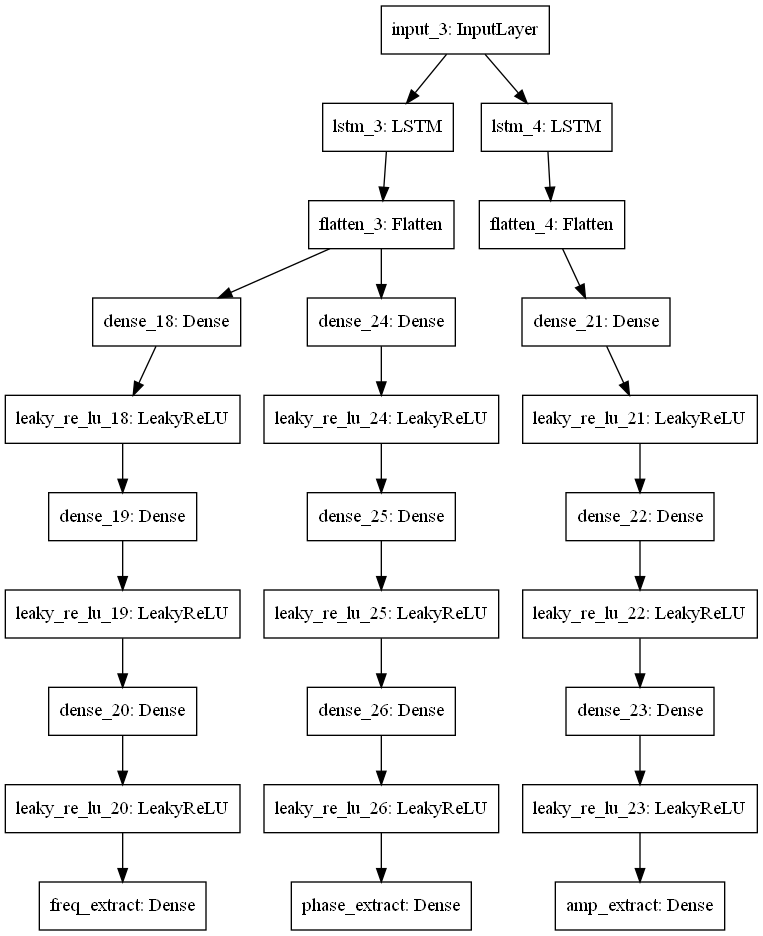

In [62]:
plot_model(model)

In [63]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
#optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)

In [64]:
model.compile(
            optimizer=optimizer, 
            loss={'freq_extract':'mse', 'amp_extract':'mse', 'phase_extract':'mse'},
            #metrics=['accuracy']
            )

In [65]:
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   min_delta=.01,
                   verbose=1, # allows you to see more info per epoch
                   patience=20) # patience is how many validations to wait with nothing learned (patience * validation_freq)

mc = ModelCheckpoint(modelSaveFile, 
                     monitor='val_loss', 
                     mode='min', 
                     verbose=1, 
                     save_best_only=True)

In [66]:
#Setup Logging
logDir = "logging" + "\\" + modelType + "\\" + modelName + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=logDir)

#Train the model
startTime = datetime.now().timestamp()
history = model.fit(x=train_features, 
                    y={'freq_extract':train_freq_labels, 
                       'amp_extract':train_amp_labels,
                       'phase_extract':train_phase_labels},
                    validation_data=(valid_features, 
                      {'freq_extract':valid_freq_labels, 
                       'amp_extract':valid_amp_labels,                       
                       'phase_extract':valid_phase_labels}),
                    epochs=no_epochs,
                    callbacks=[tensorboard, es, mc],
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=verbosity)
executionTime = (datetime.now().timestamp() - startTime)
print(f"Training took {timedelta(seconds=executionTime)}")

Epoch 1/300
11/11 [==============================] - ETA: 0s - loss: 2325.5959 - freq_extract_loss: 27.7327 - amp_extract_loss: 12.4375 - phase_extract_loss: 2285.4258
Epoch 00001: val_loss improved from inf to 2024.41943, saving model to models\DNN\nanoConvPaper_v5.2_pred3.h5
11/11 [==============================] - 7s 609ms/step - loss: 2325.5959 - freq_extract_loss: 27.7327 - amp_extract_loss: 12.4375 - phase_extract_loss: 2285.4258 - val_loss: 2024.4194 - val_freq_extract_loss: 19.0223 - val_amp_extract_loss: 1.9049 - val_phase_extract_loss: 2003.4923
Epoch 2/300
11/11 [==============================] - ETA: 0s - loss: 1167.8458 - freq_extract_loss: 8.3859 - amp_extract_loss: 1.0584 - phase_extract_loss: 1158.4015
Epoch 00002: val_loss improved from 2024.41943 to 723.31140, saving model to models\DNN\nanoConvPaper_v5.2_pred3.h5
11/11 [==============================] - 3s 283ms/step - loss: 1167.8458 - freq_extract_loss: 8.3859 - amp_extract_loss: 1.0584 - phase_extract_loss: 1158.4

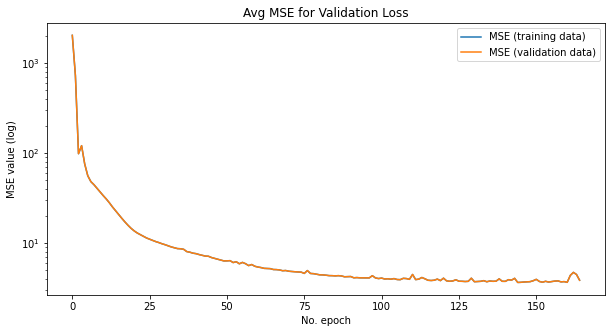

In [68]:
# Plot history: MSE
plt.figure(figsize=(10,5))
plt.plot(history.history['val_loss'], label='MSE (training data)')
plt.plot(history.history['val_loss'], label='MSE (validation data)')
plt.semilogy()
plt.title('Avg MSE for Validation Loss')
plt.ylabel('MSE value (log)')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.show()

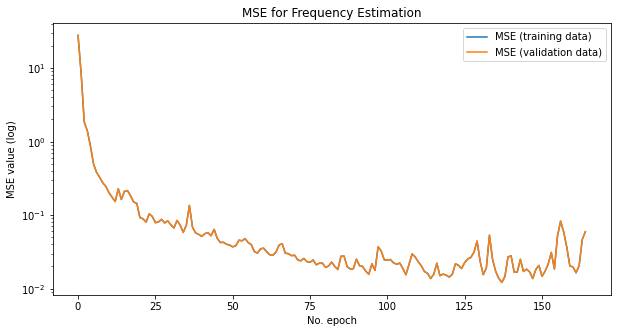

In [69]:
# Plot history: MSE
plt.figure(figsize=(10,5))
plt.plot(history.history['freq_extract_loss'], label='MSE (training data)')
plt.plot(history.history['freq_extract_loss'], label='MSE (validation data)')
plt.semilogy()
plt.title('MSE for Frequency Estimation')
plt.ylabel('MSE value (log)')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.show()

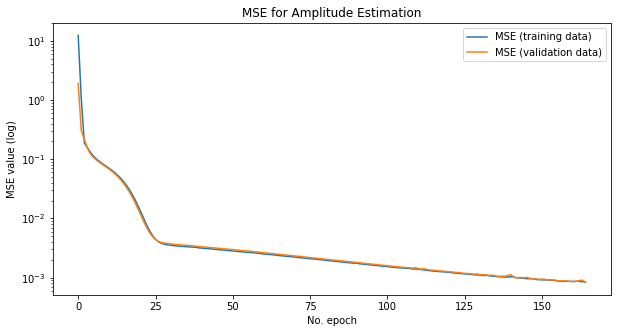

In [70]:
# Plot history: MSE
plt.figure(figsize=(10,5))
plt.plot(history.history['amp_extract_loss'], label='MSE (training data)')
plt.plot(history.history['val_amp_extract_loss'], label='MSE (validation data)')
plt.semilogy()
plt.title('MSE for Amplitude Estimation')
plt.ylabel('MSE value (log)')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.show()

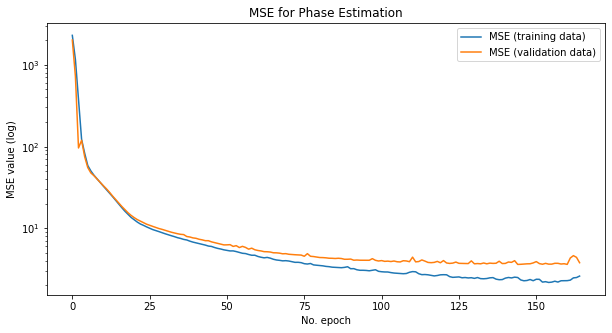

In [71]:
# Plot history: MSE
plt.figure(figsize=(10,5))
plt.plot(history.history['phase_extract_loss'], label='MSE (training data)')
plt.plot(history.history['val_phase_extract_loss'], label='MSE (validation data)')
plt.semilogy()
plt.title('MSE for Phase Estimation')
plt.ylabel('MSE value (log)')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.show()

model.save(modelSaveFile)

#Load the TensorBoard notebook extension
%load_ext tensorboard

#Open an embedded TensorBoard viewer
%tensorboard --logdir {logDir}

# LOAD & PREDICT

In [72]:
model = load_model(modelSaveFile)

In [73]:
freq_pred, amp_pred, phase_pred = model.predict(test_features)

In [74]:
pred_df = pd.DataFrame({
    'pred_freq': freq_pred.flatten(),
    'test_freq': test_freq_labels.flatten(),
    'pred_amp': amp_pred.flatten(),
    'test_amp': test_amp_labels.flatten(),
    'pred_phase': phase_pred.flatten(),
    'test_phase': test_phase_labels.flatten(),
    'snr': test_snr_labels.flatten()
})
#print(pred_df.to_string())
pred_df.head()

,pred_freq,test_freq,pred_amp,test_amp,pred_phase,test_phase,snr
0,9.569033,9.555556,0.182559,0.2,91.970581,90.0,28
1,6.137943,6.222222,0.470438,0.5,67.718674,70.0,14
2,6.222581,6.222222,0.146389,0.1,31.605223,30.0,16
3,6.277508,6.222222,0.280256,0.3,61.207001,60.0,14
4,4.011080,4.000000,0.282686,0.3,20.189110,20.0,30


In [75]:
def split_change(df, filer_col, value, true_col, pred_col):
    new_df = df.loc[df[filer_col] == value]
    tc = new_df[true_col].values
    pc = new_df[pred_col].values
    chng = np.abs((pc - tc)/tc)
    #Need to mask invalid numbers (Inf & NaN)
    md = np.ma.masked_invalid(chng)
    #Return Masked Average
    return np.ma.average(md)*100

In [76]:
snr_vals = np.unique(pred_df.snr)[::-1]

snr_chng_freq = []
for snr in snr_vals:
    snr_chng_freq.append(split_change(pred_df, 'snr', snr, 'test_freq', 'pred_freq'))

snr_chng_amp = []
for snr in snr_vals:
    snr_chng_amp.append(split_change(pred_df, 'snr', snr, 'test_amp', 'pred_amp'))

snr_chng_phase = []
for snr in snr_vals:
    snr_chng_phase.append(split_change(pred_df, 'snr', snr, 'test_phase', 'pred_phase'))

print(snr_vals)
print(snr_chng_phase)

[30 28 26 24 22 20 18 16 14 12 10  8  6  4]
[1.5079841026071072, 1.6051217469714936, 1.4947967917677951, 1.633862733323074, 1.4963173306915956, 2.2525329526476687, 2.501909112571774, 3.1107600968015308, 3.6034070209870857, 3.464931878807931, 3.5687271459375722, 6.103267920754553, 7.790811555643919, 9.245441860258067]


new_df = pred_df.loc[pred_df['snr'] == 15]
tc = new_df['test_phase'].values
pc = new_df['pred_phase'].values
chng = (pc - tc)/tc
md = np.ma.masked_invalid(chng)
print(md)
print(np.ma.average(md)*100)

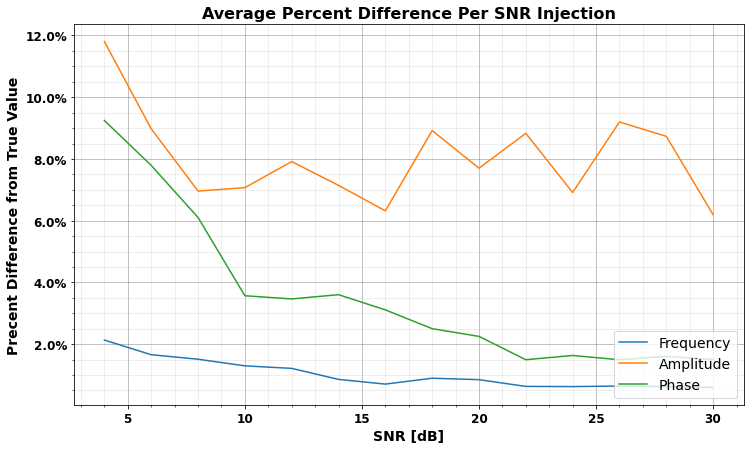

In [77]:
fig = plt.figure(figsize =(12, 7)) 
ax = fig.add_subplot(111)
bp = ax.plot(snr_vals, snr_chng_freq, snr_vals, snr_chng_amp, snr_vals, snr_chng_phase)
plt.yticks(weight='bold', fontsize=12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(weight='bold', fontsize=12)
plt.legend(['Frequency', 'Amplitude', 'Phase'], loc='lower right', prop={'size': 14})
plt.title('Average Percent Difference Per SNR Injection', weight='bold', fontsize=16)
plt.xlabel('SNR [dB]', weight='bold', fontsize=14)
plt.ylabel('Precent Difference from True Value', weight='bold', fontsize=14)
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

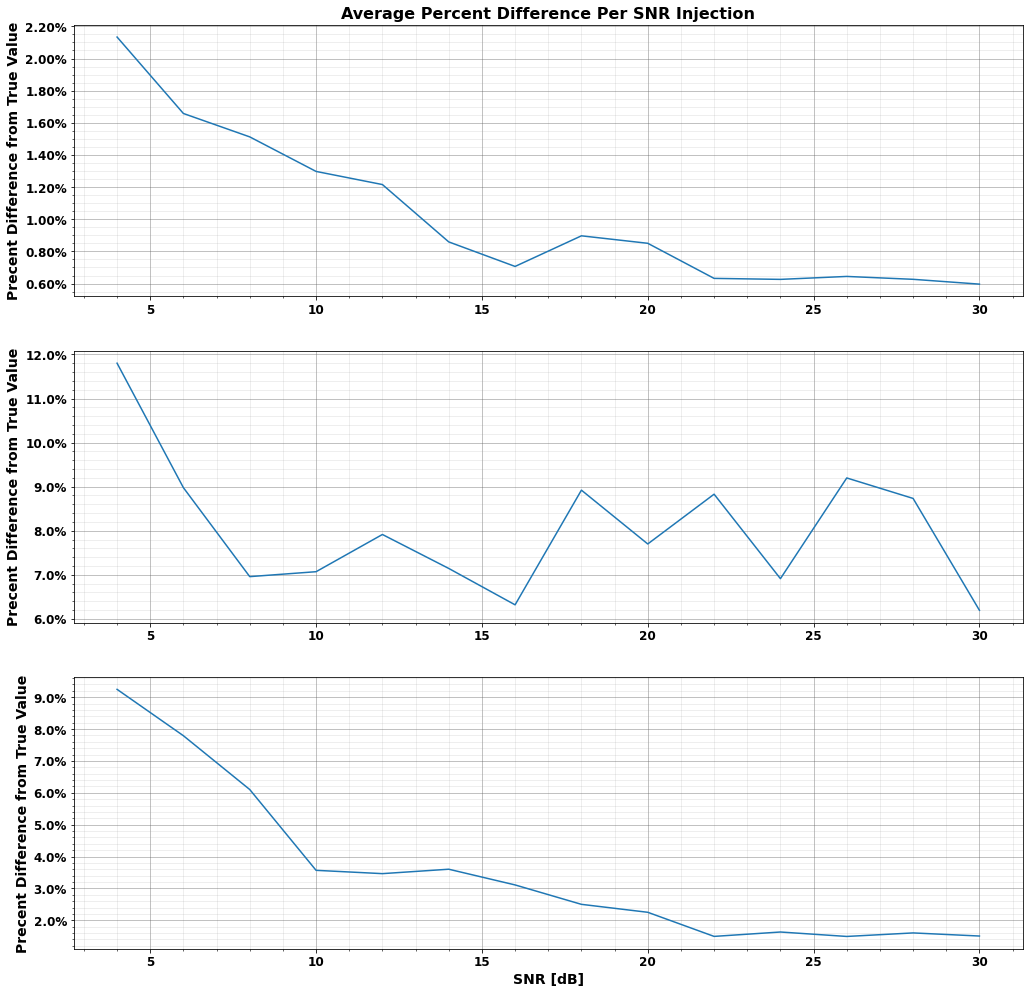

In [78]:
#FREQUENCY
fig = plt.figure(figsize =(17, 17)) 
ax1 = fig.add_subplot(311)
bp1 = ax1.plot(snr_vals, snr_chng_freq)
plt.xticks(weight='bold', fontsize=12)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.yticks(weight='bold', fontsize=12)
plt.title('Average Percent Difference Per SNR Injection', weight='bold', fontsize=16)
#plt.xlabel('SNR dB', weight='bold', fontsize=14)
plt.ylabel('Precent Difference from True Value', weight='bold', fontsize=14)
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

#AMPLITUDE
#fig = plt.figure(figsize =(12, 7)) 
ax2 = fig.add_subplot(312)
bp2 = ax2.plot(snr_vals, snr_chng_amp)
plt.xticks(weight='bold', fontsize=12)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.yticks(weight='bold', fontsize=12)
#plt.title('Average Percent Difference Per SNR Injection', weight='bold', fontsize=16)
#plt.xlabel('SNR dB', weight='bold', fontsize=14)
plt.ylabel('Precent Difference from True Value', weight='bold', fontsize=14)
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

#PHASE
#fig = plt.figure(figsize =(12, 7)) 
ax3 = fig.add_subplot(313)
bp3 = ax3.plot(snr_vals, snr_chng_phase)
plt.xticks(weight='bold', fontsize=12)
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.yticks(weight='bold', fontsize=12)
#plt.title('Average Percent Difference Per SNR Injection', weight='bold', fontsize=16)
plt.xlabel('SNR [dB]', weight='bold', fontsize=14)
plt.ylabel('Precent Difference from True Value', weight='bold', fontsize=14)
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show()

# PLOT RESULTS

In [79]:
freq_results = []
freq_names = []
for freqs in np.unique(test_freq_labels):
    freq_results.append(freq_pred[np.where(test_freq_labels == freqs)[0]].flatten())
    freq_names.append(freqs.round(2))

amp_results = []
amp_names = []
for amps in np.unique(test_amp_labels):
    amp_results.append(amp_pred[np.where(test_amp_labels == amps)[0]].flatten())
    amp_names.append(amps.round(2))

phase_results = []
phase_names = []
for phases in np.unique(test_phase_labels):
    phase_results.append(phase_pred[np.where(test_phase_labels == phases)[0]].flatten())
    phase_names.append(phases.round(2))    

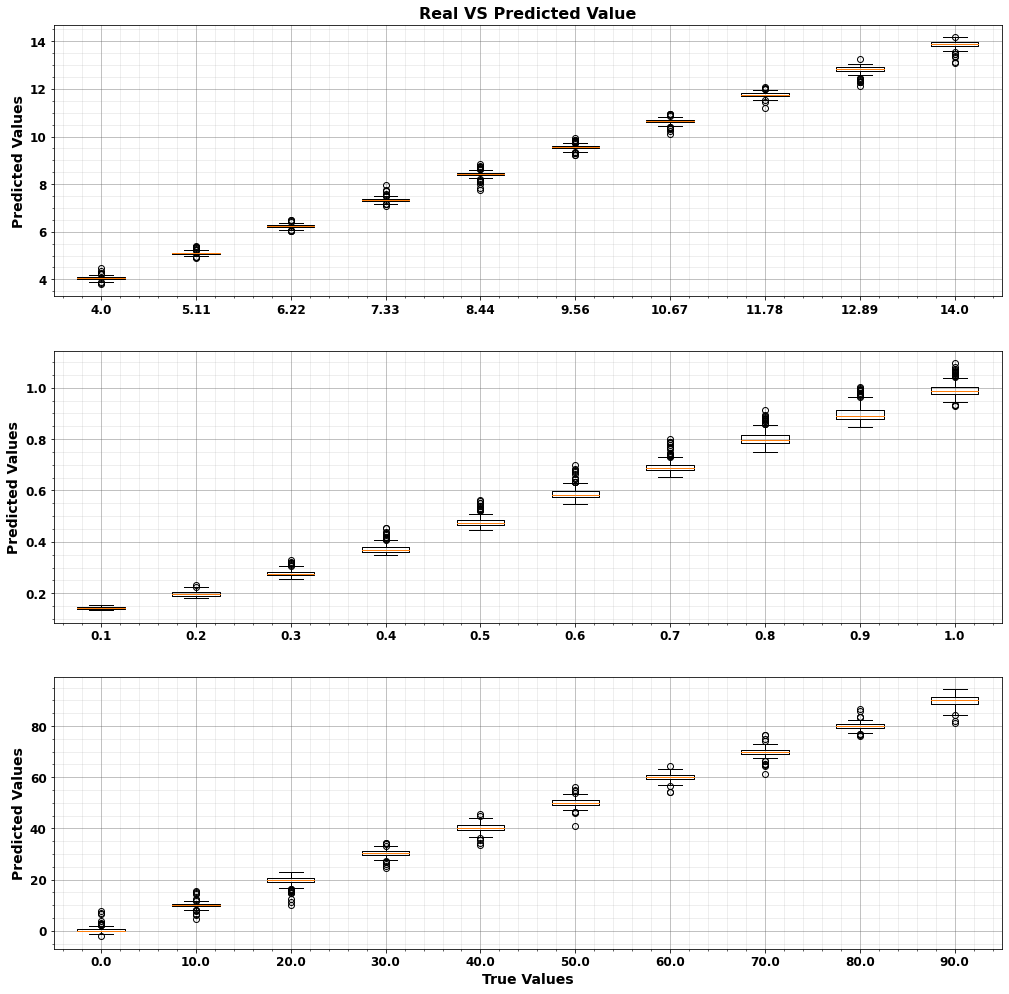

In [80]:
#Plot Box Plot

#FREQUENCY
fig = plt.figure(figsize =(17, 17)) 
ax1 = fig.add_subplot(311)
bp1 = ax1.boxplot(freq_results)
ax1.set_xticklabels(freq_names, weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.title('Real VS Predicted Value', weight='bold', fontsize=16)
#plt.xlabel('True Values', weight='bold', fontsize=14)
plt.ylabel('Predicted Values', weight='bold', fontsize=14)
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

#AMPLITUDE
#fig = plt.figure(figsize =(12, 7)) 
ax2 = fig.add_subplot(312)
bp2 = ax2.boxplot(amp_results)
ax2.set_xticklabels(amp_names, weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
#plt.title('Model Real VS Predicted Value Comparison', weight='bold', fontsize=16)
#plt.xlabel('True Values', weight='bold', fontsize=14)
plt.ylabel('Predicted Values', weight='bold', fontsize=14)
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

#PHASE
#fig = plt.figure(figsize =(12, 7)) 
ax3 = fig.add_subplot(313)
bp3 = ax3.boxplot(phase_results)
ax3.set_xticklabels(phase_names, weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
#plt.title('Model Real VS Predicted Value Comparison', weight='bold', fontsize=16)
plt.xlabel('True Values', weight='bold', fontsize=14)
plt.ylabel('Predicted Values', weight='bold', fontsize=14)
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

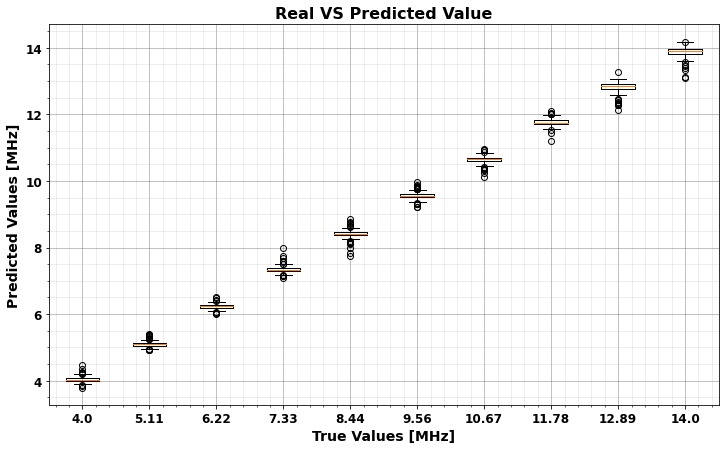

In [81]:
fig = plt.figure(figsize =(12, 7)) 
ax = fig.add_subplot(111)
bp = ax.boxplot(freq_results)
plt.yticks(weight='bold', fontsize=12)
ax.set_xticklabels(freq_names, weight='bold', fontsize=12)
plt.title('Real VS Predicted Value', weight='bold', fontsize=16)
plt.xlabel('True Values [MHz]', weight='bold', fontsize=14)
plt.ylabel('Predicted Values [MHz]', weight='bold', fontsize=14)
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show(bp)

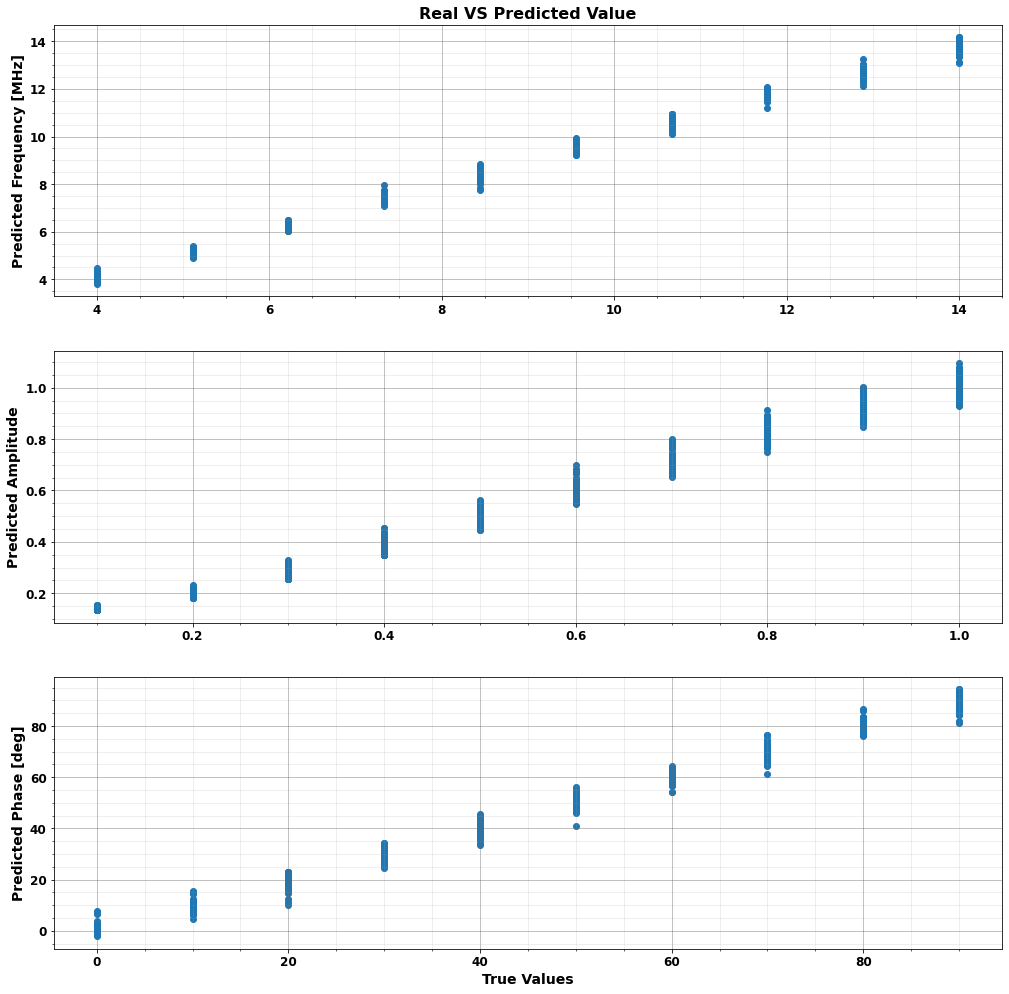

In [82]:
#Plot Scatter Plot

#FREQUENCY
fig = plt.figure(figsize =(17, 17)) 
ax1 = fig.add_subplot(311)
sp1 = ax1.scatter(test_freq_labels, freq_pred)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.title('Real VS Predicted Value', weight='bold', fontsize=16)
plt.ylabel('Predicted Frequency [MHz]', weight='bold', fontsize=14)
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

#AMPLITUDE
ax2 = fig.add_subplot(312)
sp2 = ax2.scatter(test_amp_labels, amp_pred)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.ylabel('Predicted Amplitude', weight='bold', fontsize=14)
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

#PHASE
ax3 = fig.add_subplot(313)
sp3 = ax3.scatter(test_phase_labels, phase_pred)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.xlabel('True Values', weight='bold', fontsize=14)
plt.ylabel('Predicted Phase [deg]', weight='bold', fontsize=14)
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show()

In [83]:
test_labels = [test_freq_labels, test_amp_labels, test_phase_labels]
pred = [freq_pred, amp_pred, phase_pred]
features = ['Frequency', 'Amplitude', 'Phase']

print("Features |   MAE   |   MSE   |   R^2")
print("--------------------------------------")
for ii in range(len(test_labels)):
    mae = round(metrics.mean_absolute_error(test_labels[ii], pred[ii]),5)
    mse = round(metrics.mean_squared_error(test_labels[ii], pred[ii]),5)
    r2 = round(metrics.r2_score(test_labels[ii], pred[ii]),5)
    print(f"{features[ii]:9}| {mae} | {mse} | {r2}")

Features |   MAE   |   MSE   |   R^2
--------------------------------------
Frequency| 0.08425 | 0.01709 | 0.99834
Amplitude| 0.02511 | 0.00095 | 0.98883
Phase    | 1.18236 | 3.06875 | 0.99615


In [84]:
for num in np.arange(5):
    print(f"Predicted Frequency {num}: {freq_pred[num][0]:.3f},  Actual Frequency {num}: {test_freq_labels[num]:.3f}")

Predicted Frequency 0: 9.569,  Actual Frequency 0: 9.556
Predicted Frequency 1: 6.138,  Actual Frequency 1: 6.222
Predicted Frequency 2: 6.223,  Actual Frequency 2: 6.222
Predicted Frequency 3: 6.278,  Actual Frequency 3: 6.222
Predicted Frequency 4: 4.011,  Actual Frequency 4: 4.000


In [85]:
for num in np.arange(5):
    print(f"Predicted Amplitude {num}: {amp_pred[num][0]:.3f},  Actual Amplitude {num}: {test_amp_labels[num]:.3f}")

Predicted Amplitude 0: 0.183,  Actual Amplitude 0: 0.200
Predicted Amplitude 1: 0.470,  Actual Amplitude 1: 0.500
Predicted Amplitude 2: 0.146,  Actual Amplitude 2: 0.100
Predicted Amplitude 3: 0.280,  Actual Amplitude 3: 0.300
Predicted Amplitude 4: 0.283,  Actual Amplitude 4: 0.300


In [86]:
for num in np.arange(5):
    print(f"Predicted Phase {num}: {phase_pred[num][0]:.3f},  Actual Phase {num}: {test_phase_labels[num]:.3f}")

Predicted Phase 0: 91.971,  Actual Phase 0: 90.000
Predicted Phase 1: 67.719,  Actual Phase 1: 70.000
Predicted Phase 2: 31.605,  Actual Phase 2: 30.000
Predicted Phase 3: 61.207,  Actual Phase 3: 60.000
Predicted Phase 4: 20.189,  Actual Phase 4: 20.000


In [87]:
avg_freq_accuracy = np.zeros((len(freq_pred),2))
for ii in range(len(amp_pred)):
    avg_freq_accuracy[ii,0] = test_freq_labels[ii] - freq_pred[ii]
    avg_freq_accuracy[ii,1] = (test_freq_labels[ii] - freq_pred[ii]) / test_freq_labels[ii] * 100

print(f'Average Frequency Differed by {np.mean(avg_freq_accuracy, axis=0)[0]:.5f}Hz which was {np.mean(np.ma.masked_invalid(avg_freq_accuracy), axis=0)[1]:.5f}%')

avg_amp_accuracy = np.zeros((len(amp_pred),2))
for ii in range(len(amp_pred)):
    avg_amp_accuracy[ii,0] = test_amp_labels[ii] - amp_pred[ii]
    avg_amp_accuracy[ii,1] = (test_amp_labels[ii] - amp_pred[ii]) / test_amp_labels[ii] * 100

print(f'Average Amplitude Differed by {np.mean(avg_amp_accuracy, axis=0)[0]:.5f}   which was {np.mean(np.ma.masked_invalid(avg_amp_accuracy), axis=0)[1]:.5f}%')

avg_phase_accuracy = np.zeros((len(phase_pred),2))
for ii in range(len(amp_pred)):
    avg_phase_accuracy[ii,0] = test_phase_labels[ii] - phase_pred[ii]
    avg_phase_accuracy[ii,1] = (test_phase_labels[ii] - phase_pred[ii]) / test_phase_labels[ii] * 100

print(f'Average   Phase   Differed by {np.mean(avg_phase_accuracy, axis=0)[0]:.5f}deg which was {np.mean(np.ma.masked_invalid(avg_phase_accuracy), axis=0)[1]:.5f}%')

Average Frequency Differed by 0.02230Hz which was 0.10424%
Average Amplitude Differed by 0.00425   which was -1.88889%
Average   Phase   Differed by -0.05950deg which was 0.05011%


In [88]:
#fs = 200e6        # Simulation sampling rate (Hz)
#fs_adc = 100e6    # ADC sampling rate (Hz)
#t_end = 1e-5     # Simulation end time (seconds)
#t = np.linspace(0, t_end, int(fs*t_end))

print(f"The Simulation Sampling Rate is {fs}Hz")
print(f"The end simulation time is {t_end}s")
print(f"There are {len(t)} elements per sample")

The Simulation Sampling Rate is 200000000.0Hz
The end simulation time is 1e-05s
There are 2000 elements per sample


In [89]:
#Create signal from predicted features
test_labeled_signals = []
test_pred_signals = []
for ii in range(len(amp_pred)):
    test_labeled_signals.append(test_amp_labels[ii]*np.sin(test_freq_labels[ii]*2*np.pi*t*10e5 - np.radians(test_phase_labels[ii])))
    test_pred_signals.append(amp_pred[ii][0]*np.sin(freq_pred[ii][0]*2*np.pi*t*10e5 - np.radians(phase_pred[ii][0])))

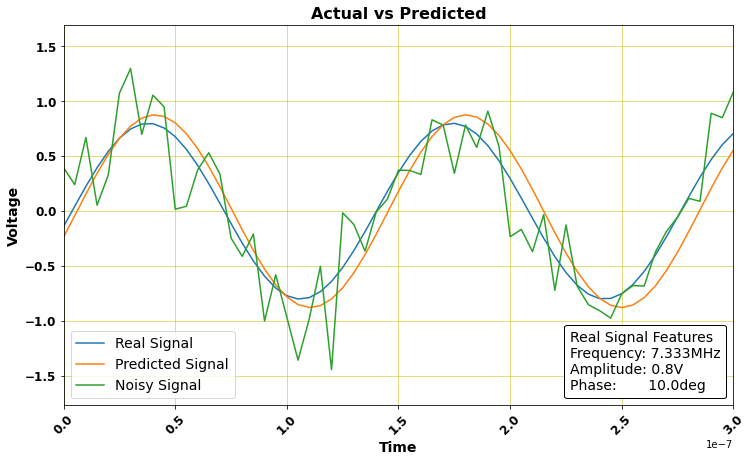

In [90]:
fignum = 30

plt.figure(figsize=(12,7))
plt.plot(t, test_labeled_signals[fignum])
plt.plot(t, test_pred_signals[fignum])
plt.plot(t, test_signal_labels[fignum])
plt.legend(['Real Signal', 'Predicted Signal', 'Noisy Signal'], loc='lower left', prop={'size': 14})
plt.title('Actual vs Predicted', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Voltage', weight='bold', fontsize=14)
at = AnchoredText(f"Real Signal Features\n\
Frequency: {test_freq_labels[fignum]:.3f}MHz\n\
Amplitude: {test_amp_labels[fignum]}V\n\
Phase:       {test_phase_labels[fignum]}deg",
                  prop=dict(size=14), frameon=True,
                  loc='lower right',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)
plt.xlim(0,0.3e-6)
plt.show()

In [91]:
print(f"Signal Frequency: {test_freq_labels[fignum]:.3f}")
print(f"Signal Amplitude: {test_amp_labels[fignum]:.3f}")
print(f"Signal Phase:     {test_phase_labels[fignum]:.3f}")

f_pred, Pxx_den_pred = signal.welch(test_pred_signals[fignum], fs, nperseg=1024)
f_input, Pxx_den_input = signal.welch(test_signal_labels[fignum], fs, nperseg=1024)

peaks_pred, _ = find_peaks(Pxx_den_pred, height=1e-14)
peaks_input, _ = find_peaks(Pxx_den_input, height=1e-13)
peaks_pred_vals = np.sort(Pxx_den_pred[peaks_pred])
peaks_input_vals = np.sort(Pxx_den_input[peaks_input])

peaks_pred_mm = np.zeros(1, dtype=int)
peaks_input_mm = np.zeros(2, dtype=int)
peaks_pred_mm[0] = np.where(Pxx_den_pred == peaks_pred_vals[-1])[0]
#peaks_pred_mm[1] = np.where(Pxx_den_pred == peaks_pred_vals[-2])[0]
peaks_input_mm[0] = np.where(Pxx_den_input == peaks_input_vals[-1])[0]
peaks_input_mm[1] = np.where(Pxx_den_input == peaks_input_vals[-2])[0]

#sfdr_pred = 20*np.log10(peaks_pred_vals[-1]/peaks_pred_vals[-2])
sfdr_pred = 0
sfdr_input = 20*np.log10(peaks_input_vals[-1]/peaks_input_vals[-2])

print(f"SFDR Improvement is {sfdr_pred - sfdr_input:.3f}dB")

Signal Frequency: 7.333
Signal Amplitude: 0.800
Signal Phase:     10.000
SFDR Improvement is -46.296dB


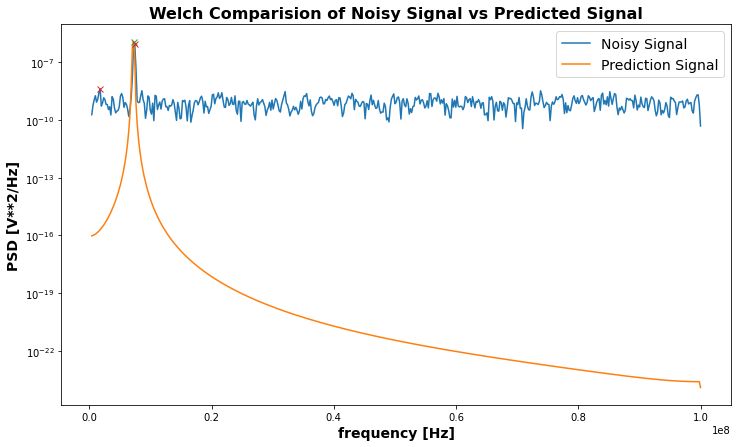

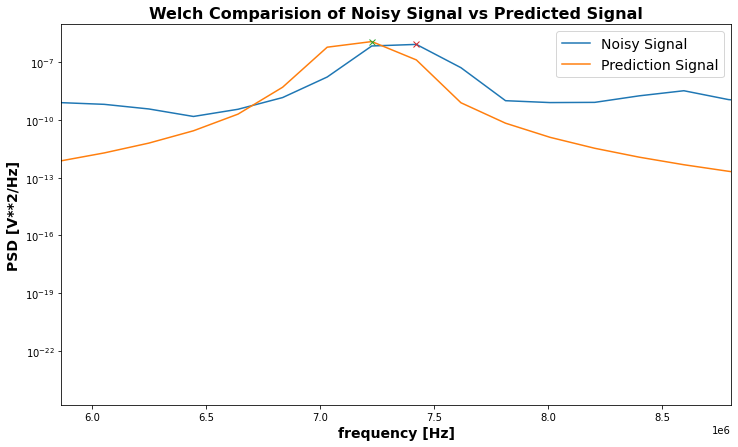

In [92]:
plt.figure(figsize=(12,7))
plt.semilogy(f_input[2:], Pxx_den_input[2:])
plt.semilogy(f_pred[2:], Pxx_den_pred[2:])
plt.plot(f_pred[peaks_pred_mm], 
         Pxx_den_pred[peaks_pred_mm], 
         "x")
plt.plot(f_input[peaks_input_mm], 
         Pxx_den_input[peaks_input_mm], 
         "x")
plt.legend(['Noisy Signal', 'Prediction Signal'], loc='best', prop={'size': 14})
plt.title('Welch Comparision of Noisy Signal vs Predicted Signal', weight='bold', fontsize=16)
plt.xlabel('frequency [Hz]', weight='bold', fontsize=14)
plt.ylabel('PSD [V**2/Hz]', weight='bold', fontsize=14)
plt.show()

plt.figure(figsize=(12,7))
plt.semilogy(f_input[2:], Pxx_den_input[2:])
plt.semilogy(f_pred[2:], Pxx_den_pred[2:])
plt.plot(f_pred[peaks_pred_mm], 
         Pxx_den_pred[peaks_pred_mm], 
         "x")
plt.plot(f_input[peaks_input_mm], 
         Pxx_den_input[peaks_input_mm], 
         "x")
plt.legend(['Noisy Signal', 'Prediction Signal'], loc='best', prop={'size': 14})
plt.title('Welch Comparision of Noisy Signal vs Predicted Signal', weight='bold', fontsize=16)
plt.xlabel('frequency [Hz]', weight='bold', fontsize=14)
plt.ylabel('PSD [V**2/Hz]', weight='bold', fontsize=14)
plt.xlim((float(test_freq_labels[fignum])*(1e6) - float(test_freq_labels[fignum])*(1e6)*0.2),(float(test_freq_labels[fignum])*(1e6) + float(test_freq_labels[fignum])*(1e6)*0.2))
plt.show()